In [ ]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/Data8/Data8.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

df_dask = dd.read_csv('/content/Data8.csv')
df = df_dask.compute()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df['Start_Time'] = dd.to_datetime(df['Start_Time'], errors='coerce')
df['Year'] = df['Start_Time'].dt.year
df['Hour'] = df['Start_Time'].dt.hour
df['Weekday'] = df['Start_Time'].dt.weekday
df['Month'] = df['Start_Time'].dt.month

In [ ]:
df= df[df['Year'] == 2020]
colonnes_a_supprimer = [
   'ID','Source', 'End_Time', 'End_Lat', 'End_Lng', 'Description', 'Street', 'City',
    'County', 'Zipcode', 'Country', 'Timezone', 'Airport_Code',
    'Wind_Chill(F)', 'Pressure(in)', 'Wind_Direction',
     'Give_Way', 'No_Exit', 'Turning_Loop',
    'Astronomical_Twilight', 'Nautical_Twilight'
]
df = df.drop(columns=colonnes_a_supprimer)
cols = ['Severity', 'Hour', 'Weekday','Month', 'Start_Lat', 'Start_Lng',
        'Temperature(F)', 'Humidity(%)', 'Visibility(mi)',
        'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition',
        'Bump', 'Crossing', 'Junction', 'Traffic_Signal','Stop','Station','Amenity',
        'Sunrise_Sunset','State']
df = df[cols].dropna()


In [ ]:
df['Sunrise_Sunset'] = df['Sunrise_Sunset'].map({'Day': 0, 'Night': 1})

In [ ]:
df["Weather_Condition"].unique().tolist()

['Light Rain',
 'Light Snow',
 'Mostly Cloudy',
 'Light Freezing Drizzle',
 'Overcast',
 'Rain',
 'Heavy Rain',
 'Clear',
 'Mist',
 'Partly Cloudy',
 'Snow',
 'Light Freezing Fog',
 'Haze',
 'Light Thunderstorms and Rain',
 'Scattered Clouds',
 'Light Drizzle',
 'Thunderstorms and Rain',
 'Fair',
 'Cloudy',
 'Smoke',
 'Fair / Windy',
 'Drizzle',
 'Mostly Cloudy / Windy',
 'Fog',
 'Heavy Thunderstorms and Rain',
 'Thunderstorm',
 'Light Freezing Rain',
 'Heavy Snow',
 'Light Ice Pellets',
 'Ice Pellets',
 'Rain Showers',
 'Cloudy / Windy',
 'Light Rain with Thunder',
 'Heavy Drizzle',
 'Thunder',
 'Rain / Windy',
 'Heavy Rain / Windy',
 'Light Snow / Windy',
 'Light Rain Showers',
 'Thunder in the Vicinity',
 'T-Storm',
 'Heavy T-Storm',
 'Showers in the Vicinity',
 'Light Rain / Windy',
 'Patches of Fog',
 'N/A Precipitation',
 'Heavy T-Storm / Windy',
 'Partly Cloudy / Windy',
 'Thunder / Windy',
 'Shallow Fog',
 'Light Rain Shower',
 'T-Storm / Windy',
 'Haze / Windy',
 'Drizzle and 

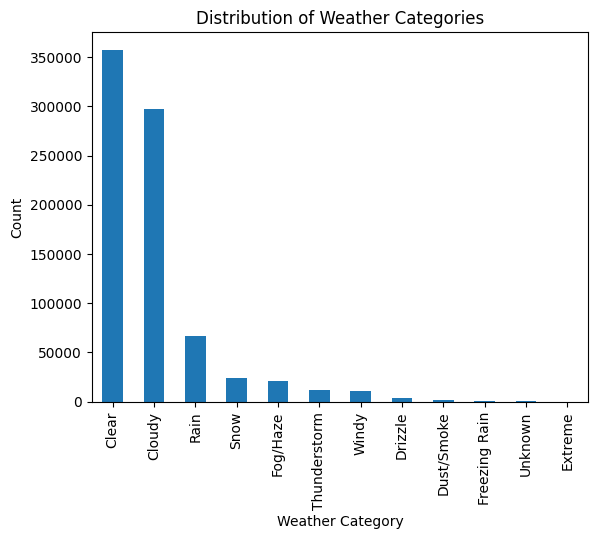

In [ ]:
def simplify_weather_condition(condition):
    condition = condition.lower()

    if 'tornado' in condition:
        return 'Extreme'
    elif 'thunder' in condition or 't-storm' in condition or 'hail' in condition:
        return 'Thunderstorm'
    elif ('snow' in condition or 'sleet' in condition or
          'wintry mix' in condition or 'ice pellets' in condition or
          'snow grains' in condition or 'blowing snow' in condition):
        return 'Snow'
    elif 'freezing rain' in condition or 'freezing drizzle' in condition:
        return 'Freezing Rain'
    elif 'rain' in condition or 'shower' in condition:
        return 'Rain'
    elif 'drizzle' in condition:
        return 'Drizzle'
    elif ('fog' in condition or 'mist' in condition or
          'haze' in condition or 'partial fog' in condition or
          'shallow fog' in condition or 'patches of fog' in condition):
        return 'Fog/Haze'
    elif ('dust' in condition or 'sand' in condition or
          'smoke' in condition):
        return 'Dust/Smoke'
    elif ('wind' in condition or 'windy' in condition or
          'squall' in condition):
        return 'Windy'
    elif 'clear' in condition or 'fair' in condition:
        return 'Clear'
    elif 'cloud' in condition or 'overcast' in condition:
        return 'Cloudy'
    elif 'n/a' in condition:
        return 'Unknown'
    else:
        return 'Other'



# Application
df['Weather_Condition_Simplified'] = df['Weather_Condition'].apply(simplify_weather_condition)
df['Weather_Condition_Simplified'].value_counts().plot(kind='bar', title='Distribution of Weather Categories')
plt.xlabel('Weather Category')
plt.ylabel('Count')
plt.show()


In [ ]:
df_sample = df.sample(frac=0.01)


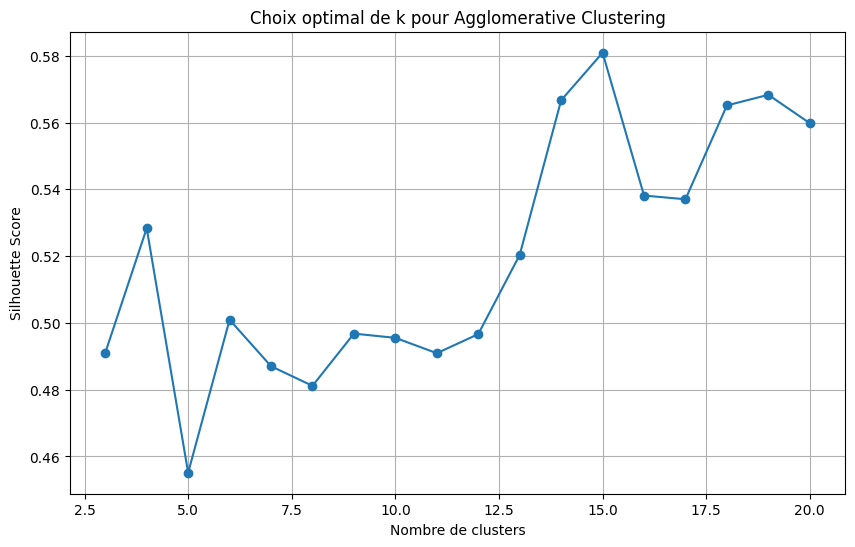

Meilleur k = 15


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np

X = df_sample[['Start_Lat', 'Start_Lng']].sample(n=min(10000, len(df_sample)), random_state=42)

cluster_range = range(3, 21)
silhouette_scores = []

for k in cluster_range:
    model = AgglomerativeClustering(n_clusters=k, linkage='complete')
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette Score")
plt.title("Choix optimal de k pour Agglomerative Clustering")
plt.grid(True)
plt.show()

best_k = cluster_range[np.argmax(silhouette_scores)]
print(f"Meilleur k = {best_k}")


In [ ]:
sampled_df = df_sample.sample(n=min(10000, len(df_sample)), random_state=42)
X = sampled_df[['Start_Lat', 'Start_Lng']]

model = AgglomerativeClustering(n_clusters=best_k, linkage='complete')
sampled_df['Agglomerative_Cluster'] = model.fit_predict(X)


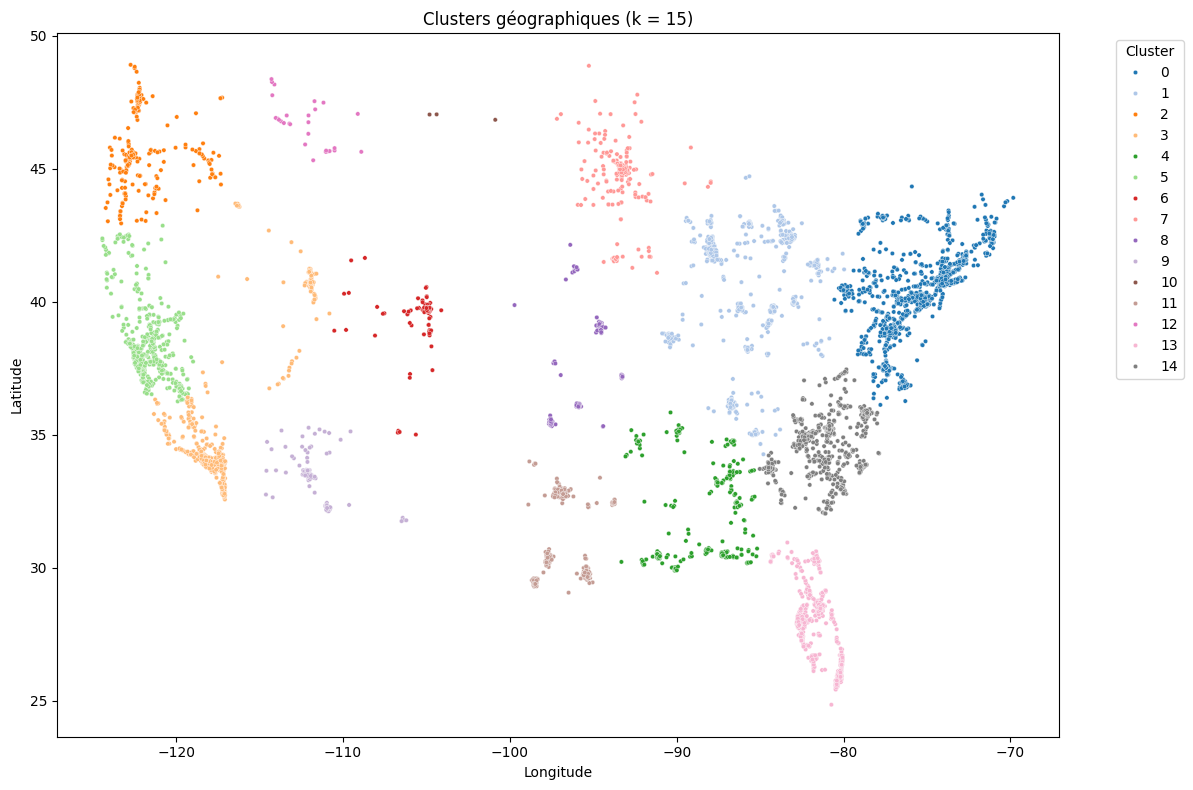

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(data=sampled_df, x='Start_Lng', y='Start_Lat', hue='Agglomerative_Cluster', palette='tab20', s=10)
plt.title(f"Clusters géographiques (k = {best_k})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
clusters = sampled_df['Agglomerative_Cluster'].value_counts().head(10).index.tolist()
zone_risque = sampled_df[sampled_df['Agglomerative_Cluster'].isin(clusters)].copy()

<Axes: xlabel='Agglomerative_Cluster', ylabel='Visibility(mi)'>

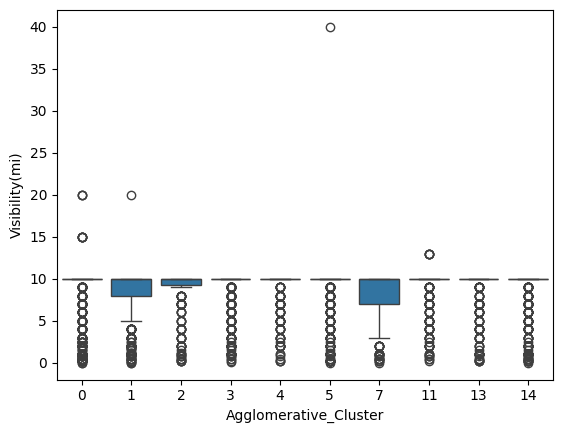

In [ ]:
sns.boxplot(data=zone_risque, x='Agglomerative_Cluster', y='Visibility(mi)')


<Axes: xlabel='Sunrise_Sunset', ylabel='count'>

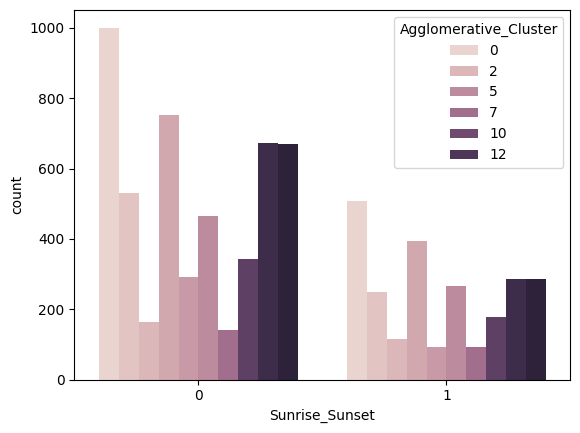

In [ ]:
sns.countplot(data=zone_risque, x='Sunrise_Sunset', hue='Agglomerative_Cluster')


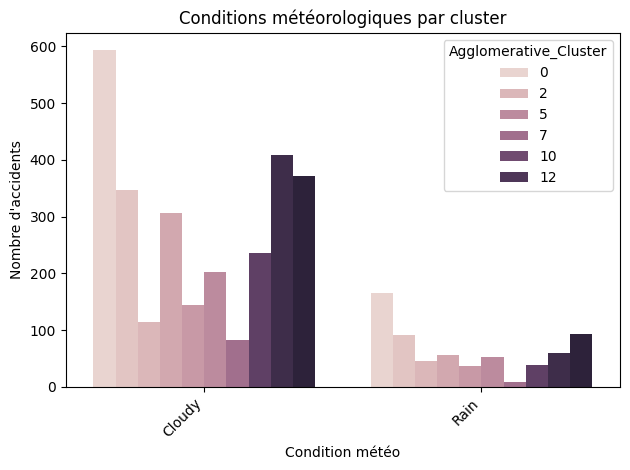

In [ ]:
top_conditions = zone_risque['Weather_Condition'].value_counts().head(20).index

sns.countplot(data=zone_risque[zone_risque['Weather_Condition_Simplified'].isin(top_conditions)],
              x='Weather_Condition_Simplified', hue='Agglomerative_Cluster')
plt.xticks(rotation=45, ha='right')  # Incliner les étiquettes
plt.title("Conditions météorologiques par cluster")
plt.xlabel("Condition météo")
plt.ylabel("Nombre d'accidents")
plt.tight_layout()
plt.show()

<Axes: xlabel='Severity', ylabel='count'>

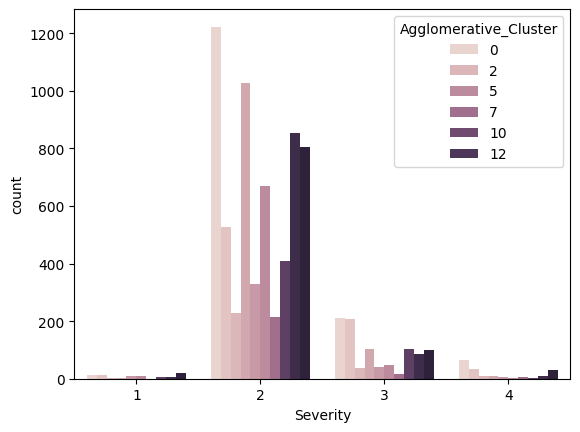

In [ ]:
sns.countplot(data=zone_risque, x='Severity', hue='Agglomerative_Cluster')


<Axes: xlabel='Agglomerative_Cluster', ylabel='count'>

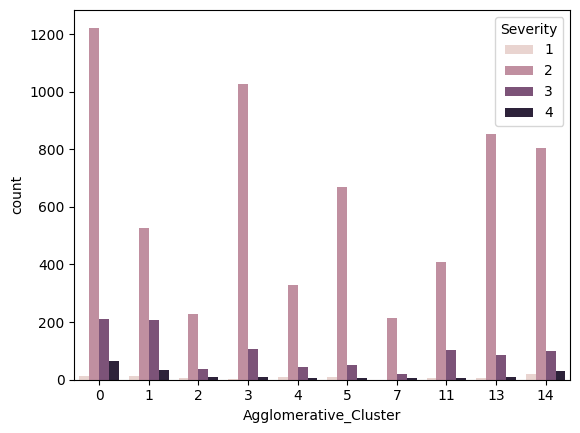

In [ ]:
sns.countplot(data=zone_risque, x='Agglomerative_Cluster', hue='Severity')


<Axes: xlabel='Hour', ylabel='Count'>

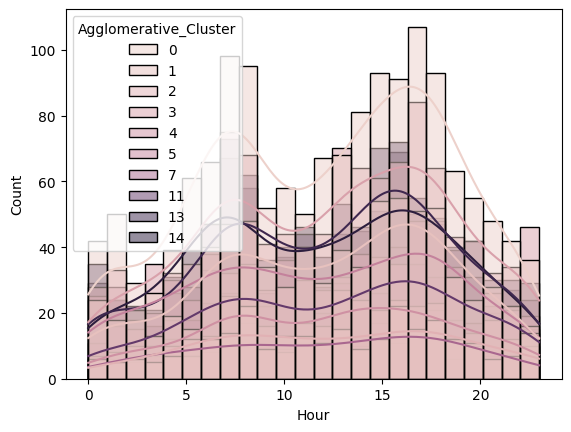

In [ ]:
sns.histplot(data=zone_risque, x='Hour', hue='Agglomerative_Cluster', bins=24, kde=True)


In [ ]:
# Stats descriptives par cluster
summary_stats = zone_risque.groupby('Agglomerative_Cluster')[['Severity', 'Visibility(mi)', 'Wind_Speed(mph)']].describe()
print(summary_stats)

                      Severity                                               \
                         count      mean       std  min  25%  50%  75%  max   
Agglomerative_Cluster                                                         
0                       1510.0  2.216556  0.520097  1.0  2.0  2.0  2.0  4.0   
1                        780.0  2.337179  0.584702  1.0  2.0  2.0  3.0  4.0   
2                        278.0  2.183453  0.494168  1.0  2.0  2.0  2.0  4.0   
3                       1146.0  2.106457  0.343387  1.0  2.0  2.0  2.0  4.0   
4                        385.0  2.114286  0.411335  1.0  2.0  2.0  2.0  4.0   
5                        731.0  2.065663  0.311532  1.0  2.0  2.0  2.0  4.0   
7                        236.0  2.118644  0.384143  2.0  2.0  2.0  2.0  4.0   
11                       521.0  2.203455  0.443833  1.0  2.0  2.0  2.0  4.0   
13                       957.0  2.104493  0.359496  1.0  2.0  2.0  2.0  4.0   
14                       956.0  2.148536  0.483127  

In [ ]:
import pandas as pd

def resume_clusters(df, cluster_col='Agglomerative_Cluster'):
    results = []

    for cluster in sorted(df[cluster_col].unique()):
        group = df[df[cluster_col] == cluster]
        total = len(group)

        # Géolocalisation moyenne (approx.)
        avg_lat = group['Start_Lat'].mean()
        avg_lng = group['Start_Lng'].mean()

        # Heure de pic (mode)
        peak_hour = group['Hour'].mode()[0] if 'Hour' in group else None

        # Distribution de la gravité
        severity_dist = group['Severity'].value_counts(normalize=True).sort_index()

        # Visibilité moyenne
        visibility = group['Visibility(mi)'].mean()

        # Proportion d'accidents de nuit
        if 'Sunrise_Sunset' in group:
            night_ratio = (group['Sunrise_Sunset'] == 1).mean()
        else:
            night_ratio = None

        # Top météo
        top_weather = group['Weather_Condition_Simplified'].value_counts().idxmax() if 'Weather_Condition' in group else None

        # Construction de la ligne du tableau
        row = {
            'Cluster': cluster,
            'Nb_accidents': total,
            'Lat_moy': round(avg_lat, 2),
            'Lng_moy': round(avg_lng, 2),
            'Heure_pic': peak_hour,
            'Severity_1(%)': round(severity_dist.get(1, 0)*100, 1),
            'Severity_4(%)': round(severity_dist.get(4, 0)*100, 1),
            'Visibilité_moy.': round(visibility, 2) if pd.notna(visibility) else None,
            '% Nuit': round(night_ratio * 100, 1) if night_ratio is not None else None,
            'Top météo': top_weather
        }

        results.append(row)

    return pd.DataFrame(results)

# 🔧 Utilisation
cluster_summary = resume_clusters(sampled_df)
display(cluster_summary)


,Cluster,Nb_accidents,Lat_moy,Lng_moy,Heure_pic,Severity_1(%),Severity_4(%),Visibilité_moy.,% Nuit,Top météo
0,0,1510,40.18,-75.58,17.0,0.8,4.2,8.77,33.7,Clear
1,1,780,40.15,-85.82,16.0,1.5,4.4,8.39,31.9,Cloudy
2,2,278,45.88,-121.91,8.0,1.4,3.2,8.67,41.0,Cloudy
3,3,1146,34.70,-117.51,17.0,0.3,0.9,9.13,34.4,Clear
4,4,385,31.69,-88.95,8.0,2.1,1.3,9.04,24.4,Clear
5,5,731,38.25,-121.66,8.0,1.2,0.5,8.93,36.4,Clear
6,6,107,39.36,-105.48,8.0,2.8,6.5,8.75,29.9,Cloudy
7,7,236,44.65,-93.37,18.0,0.0,2.1,8.24,39.8,Clear
8,8,159,37.51,-95.77,17.0,1.9,1.9,8.58,22.0,Clear
9,9,154,33.25,-111.65,17.0,8.4,2.6,9.73,33.1,Clear
